# Capstone Project 1 Milestone Code

## Background

Lending Club is an online loan platform that allows individuals to take out personal loans of up to $40,000. Borrowers can apply for a loan online and will typically receive their money within a few days of submitting their application. Unlike a bank, the platform uses investors to fund loans and acts as the intermediary between investors and borrowers.

Occassionally a borrower does not pay back a loan in full and Lending Club must "Charge Off" the loan. This typically happens once a loan payment is at least 150 days past due, but can also occur earlier or later depending on the circumstances (i.e. a borrower files for bankruptcy).

## Problem

How much money does Lending Club lose to charged off loans? Is it possible to help Lending Club predict the risk of a specific borrower failing to pay off their loan? Can a model be built to minimize the risk to Lending Club investors and decrease the amount of money lost each year? 

## The Data

To answer this question I will be using Lending Club's __[dataset](https://www.lendingclub.com/info/download-data.action)__ that contains all loan information from 2007-2011. 

The original dataset includes over 140 features. I decided to start by reducing the data to 17 features of interest:
* **Funded Amount:** The amount loaned to the borrower
* **Term:** The length of the loan (either 36 months or 60 months)
* **Interest Rate:** Interest rate on the loan
* **Installment:** Loan payments
* **Grade:** LC assigned loan grade
* **Sub Grade:** LC assigned loan sub-grade 
* **Employment Title:** The job title supplied by the borrower when applying for a loan
* **Employment Length:** Borrowers length of employment 
* **Home Ownership:** Home ownership status provided by borrower: RENT, OWN, MORTGAGE, OTHER
* **Annual Income:** Annual income provided by borrower
* **Verification Status:** Indicates if income was verified by LC
* **Issue Date:** Month and year the loan was issued
* **Loan Status:** Lists whether a loan is CURRENT or CHARGED OFF
* **Purpose of Loan:** Purpose of loan provided by borrower
* **Title of Loan:** Loan title provided by borrower
* **State of Borrower:** State of residence provided by borrower
* **dti:** Debt to income ratio calculated using borrower's total monthly debt payments on the total debt obligations, divided by borrower's self-reported annual income 

In [83]:
# Import packages
%pylab inline
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
sns.set()

# Import dataset
df = pd.read_csv('LoanStats3a.csv', header = 1, dtype={'next_pymnt_d': object, 'id': object})

Populating the interactive namespace from numpy and matplotlib


/Users/ameenakhan/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [84]:
# Drop all empty columns and rows
df = df.dropna(axis = 1, how = 'all')
df = df.dropna(axis = 0, how = 'all')

# Drop columns with only 158 non-null values
df = df.iloc[:, 1:58]

# Drop additional columns not of interest
df = df.iloc[:, 1:23]
df = df.drop('funded_amnt_inv', 1)
df = df.drop('desc', 1)
df = df.drop('zip_code', 1)
df = df.drop('delinq_2yrs', 1)
df = df.drop('pymnt_plan', 1)

# Identify the rows with missing data
nans = lambda df: df[df.isnull().all(axis=1)]
nans(df)

# Drop empty rows 
df = df.drop([39788, 42540, 42541])

### Cleaning the Dataset
#### Missing Data

I found several columns with missing data and handled them as follows: 
* **Employment Title:** Missing 2624 entries. Replaced all missing information with 'Unknown'. I also had several titles with less than 20 counts, so I renamed those to 'Other'. 
* **Annual Income:** Four entries were missing income data so I replaced those with the mean annual income of \$69,136.56. 
* **Title:** Title was missing 12 values, so I replaced those with 'Unknown'

In [85]:
# Replace NaN in Employment Title with 'Unknown'
df['emp_title'] = df['emp_title'].fillna('Unknown')

# Replace values of < 20 with 'Other'
df = df.assign(emp_title=df.groupby('emp_title')['emp_title'].transform(lambda x: x if x.size>=20 else 'Other'))

# Calculate the mean of annual_inc
inc_mean = df['annual_inc'].mean()

# Replace all the missing values in annual_inc with the mean
df['annual_inc'] = df['annual_inc'].fillna(inc_mean)

## Replace NaN in title with 'Unknown'
df['title'] = df['title'].fillna('Unknown')

# Replace values of < 20 with 'Other'
df = df.assign(title=df.groupby('title')['title'].transform(lambda x: x if x.size>=20 else 'Other'))

#### Date Issued

In case I wanted to look deeper at the month and year that a loan was issued, I decided to create two additional columns: 
* **Month Issued:** the month a loan was issued
* **Year Issued:** the year a loan was issued

In [86]:
# Split issue_d into separate columns with year and month in each column
df[['issue_year','issue_month']] = df['issue_d'].str.split('-',expand=True)

# replace the incorrect years with the correct year format 
df['issue_year'] = df['issue_year'].replace({'7': '07',
                                               '8':'08',
                                            '9':'09'})

# combine the year and month columns
df.issue_d = df.issue_year.map(str) + '-' + df.issue_month

# Convert issue_d into datetime series
df.issue_d = pd.to_datetime(df.issue_d, format='%y-%b')

#### Loan Status

Since loan status is what I will be using as my independent variable throughout this project, I decided to turn it into a binomial variable as follows: 
* Fully Paid: 0
* Charged Off: 1

Note that Fully Paid means that the loan is currently up to date with all payments and is in good standing. It does not necessarily mean that the loan has been repaid in full.

In [87]:
# consolidate to two catagories
df['loan_status'] = df['loan_status'].replace({'Does not meet the credit policy. Status:Fully Paid':'Fully Paid',
                                               'Does not meet the credit policy. Status:Charged Off':'Charged Off'})

# convert fully paid to 0 and charged off to 1
df['loan_status'] = df['loan_status'].replace({'Fully Paid':0,
                                               'Charged Off':1})
df.loan_status.value_counts()

0    36104
1     6431
Name: loan_status, dtype: int64

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42535 entries, 0 to 42537
Data columns (total 19 columns):
funded_amnt            42535 non-null float64
term                   42535 non-null object
int_rate               42535 non-null object
installment            42535 non-null float64
grade                  42535 non-null object
sub_grade              42535 non-null object
emp_title              42535 non-null object
emp_length             42535 non-null object
home_ownership         42535 non-null object
annual_inc             42535 non-null float64
verification_status    42535 non-null object
issue_d                42535 non-null datetime64[ns]
loan_status            42535 non-null int64
purpose                42535 non-null object
title                  42535 non-null object
addr_state             42535 non-null object
dti                    42535 non-null float64
issue_year             42535 non-null object
issue_month            42535 non-null object
dtypes: datetime64[ns](1)

In [89]:
df.describe()

,funded_amnt,installment,annual_inc,loan_status,dti
count,42535.000000,42535.000000,4.253500e+04,42535.000000,42535.000000
mean,10821.585753,322.623063,6.913656e+04,0.151193,13.373043
std,7146.914675,208.927216,6.409334e+04,0.358241,6.726315
min,500.000000,15.670000,1.896000e+03,0.000000,0.000000
25%,5000.000000,165.520000,4.000000e+04,0.000000,8.200000
50%,9600.000000,277.690000,5.900000e+04,0.000000,13.470000
75%,15000.000000,428.180000,8.250000e+04,0.000000,18.680000
max,35000.000000,1305.190000,6.000000e+06,1.000000,29.990000


## Exploratory Data Analysis


From 2007-2011, Lending Club issued over \$460 million dollars in loans. Of the 42,535 loans issued during that time, 15.1 percent of them were charged off. These loans totaled over $73.9 million dollars. While this amount does not take into account how much a borrower repaid before the loan was charged off or how much money Lending Club investors will lose in interest that would have been paid on the loan, it's safe to say it is still a lot of money Lending Club investors are losing!

In [90]:
print('Number of Loans that are Fully Paid (0) or Charged Off (1):')
print(df.loan_status.value_counts())

a = round(6431/(36104+6431)*100,3)
print('Percentage of loans that are in default:', a) 

default = df
default = default[default.loan_status == 1]
lost = default.funded_amnt.sum()
print('Amount Lending Club loans charged off:',lost)

Number of Loans that are Fully Paid (0) or Charged Off (1):
0    36104
1     6431
Name: loan_status, dtype: int64
Percentage of loans that are in default: 15.119
Amount Lending Club loans charged off: 73906275.0


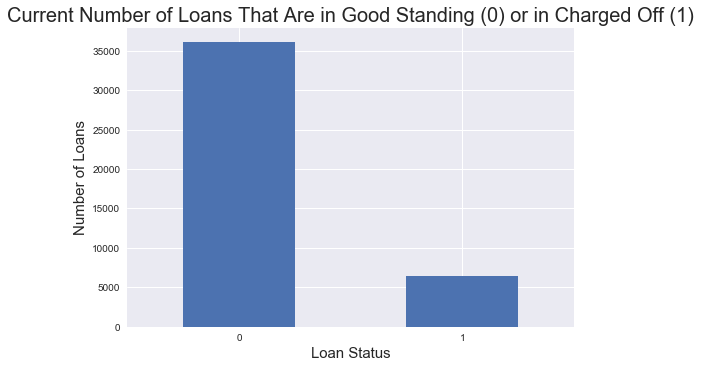

In [91]:
# Create a graph of the number of loans in either good standing or in default
df.loan_status.value_counts().plot(kind = 'bar')
plt.title('Current Number of Loans That Are in Good Standing (0) or in Charged Off (1)', fontsize=20)
plt.xlabel('Loan Status', fontsize=15)
plt.ylabel('Number of Loans', fontsize=15)
plt.xticks(rotation='horizontal')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

### Trends over time

Next I looked at the number of loans issued over time and compared it the number of loans that were charged off over time. 

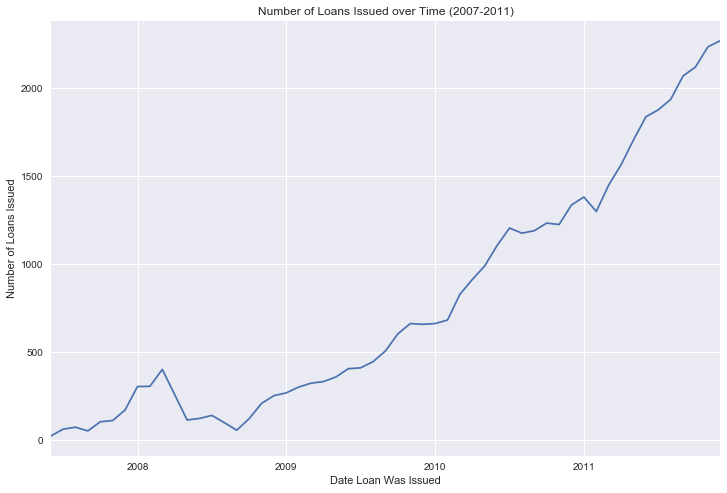

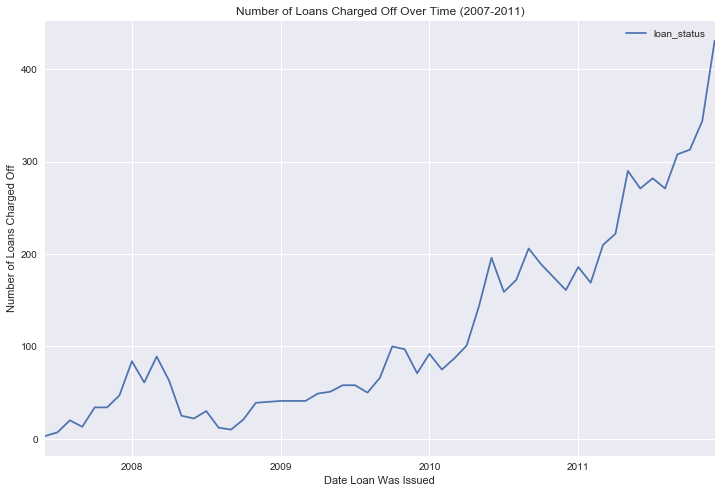

In [92]:
# Plot the number of loans issued over time
df.issue_d.value_counts().sort_index().plot(kind = 'line')
plt.title('Number of Loans Issued over Time (2007-2011)')
plt.xlabel('Date Loan Was Issued')
plt.ylabel('Number of Loans Issued')

# Filter for loan_status == 1 and set the index to issue_d (a datetime object)
time = df
time = time.set_index(time.issue_d)
time = time[['loan_status']]
time = time[time.loan_status == 1]

# Plot defaults over time
time.groupby(time.index).count().plot(kind='line')
plt.title('Number of Loans Charged Off Over Time (2007-2011)')
plt.xlabel('Date Loan Was Issued')
plt.ylabel('Number of Loans Charged Off')
plt.show()

Looking at the graphs, it appears the number of loans that are charged off has remained proportionally consistent over time. Additional statistical analysis will allow me to see if there is a more significant relationship here.

### Additional Visual Analysis Not Included In Report

I performed additional analysis that was not included in the report but wanted to include it here:

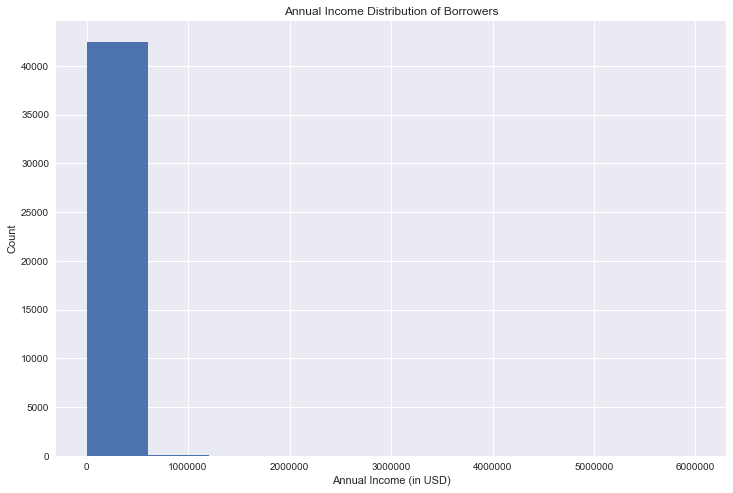

In [93]:
# Plot annual income distribution of borrowers
plt.hist(df.annual_inc)
plt.title('Annual Income Distribution of Borrowers')
plt.xlabel('Annual Income (in USD)')
plt.ylabel('Count')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

Due to outliers in the dataset, I split the data into to and graphed it: 

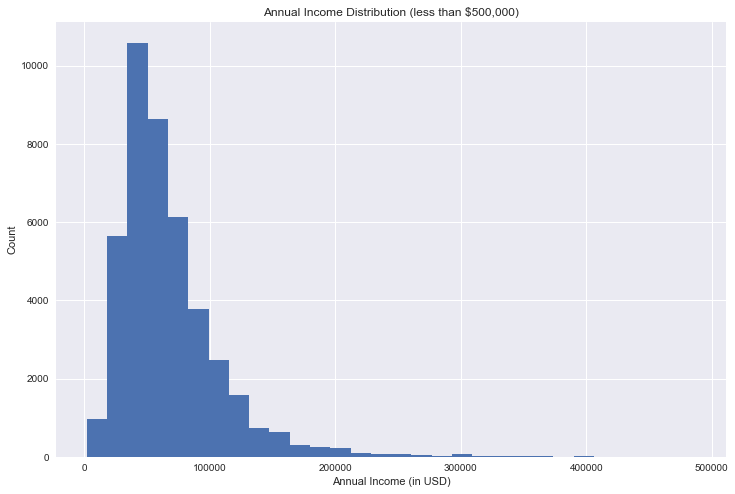

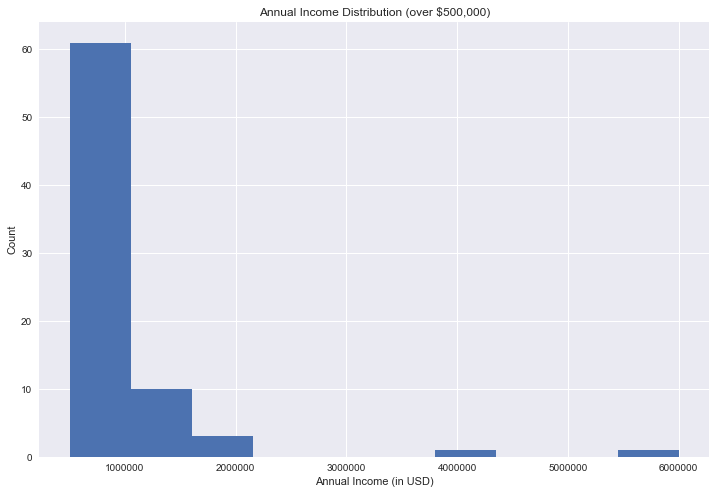

In [94]:
# Create a graph for borrowers who made over $500,000
a = df[df.annual_inc < 500000]
plt.hist(a.annual_inc, 30)
plt.title('Annual Income Distribution (less than $500,000)')
plt.xlabel('Annual Income (in USD)')
plt.ylabel('Count')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

# Create a graph for borrowers who made over $500,000
b = df[df.annual_inc > 500000]
plt.hist(b.annual_inc)
plt.title('Annual Income Distribution (over $500,000)')
plt.xlabel('Annual Income (in USD)')
plt.ylabel('Count')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

I then used a boxplot to further show the impact of the outliers:

count    4.253500e+04
mean     6.913656e+04
std      6.409334e+04
min      1.896000e+03
25%      4.000000e+04
50%      5.900000e+04
75%      8.250000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

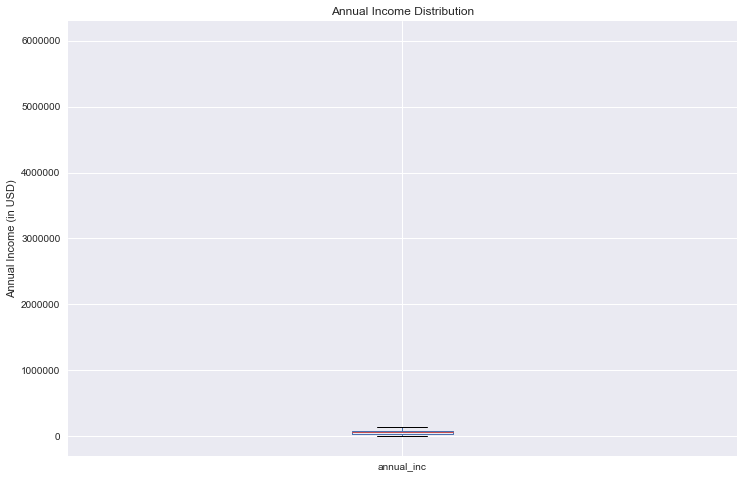

In [95]:
# Create a boxplot of annual_inc
df.boxplot(column=['annual_inc'])
plt.title('Annual Income Distribution')
plt.ylabel('Annual Income (in USD)')

df.annual_inc.describe()

#### How does income compare to loan status?

,mean,std
loan_status,,
0,70164.277724,66280.247602
1,63366.870530,49684.103432


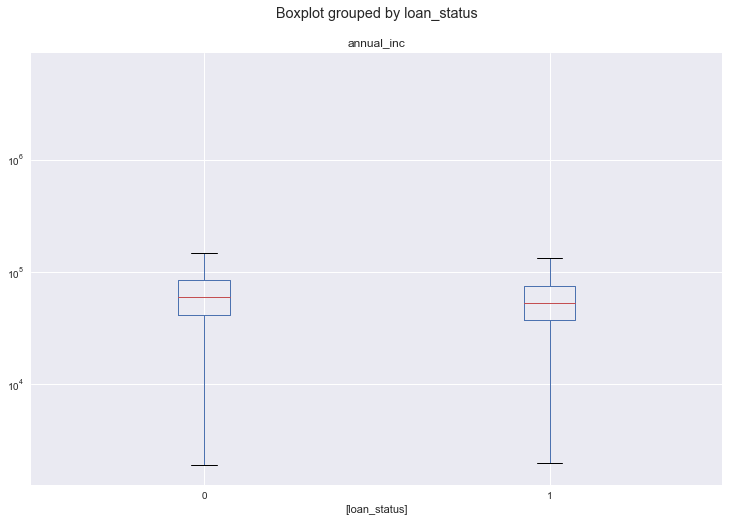

In [96]:
df.boxplot(column=['annual_inc'],by = ['loan_status']).set_yscale('log')
pd.DataFrame(df.groupby( ['loan_status'])['annual_inc'].describe().loc[:,['mean','std']])

It appears there might not be much of a difference between income of borrowers, however the stastical analysis performed below shows that there actually is a difference. 

#### Default per Loan Type

Because I decided not to use the Grade in my stastical analysis (it is already a measure of risk), I did not include the below in my milestone report but wanted to include it here to show work done. 

One of the most interesting results from my exploratory data anaylsis was the trends in defaults per loan type.

When a loan is issued to a borrower Lending Club gives it a grade rating. The grade is based on an applicants loan application and credit report and is used to determine their interest rate on the loan. Borrowers with the lowest risk (A) have a lower interest rate, while borrowers with the highest risk (G) have the highest interest rates.

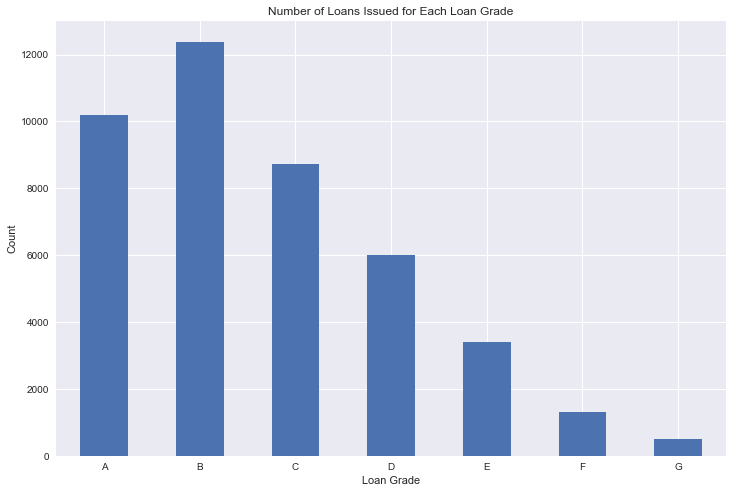

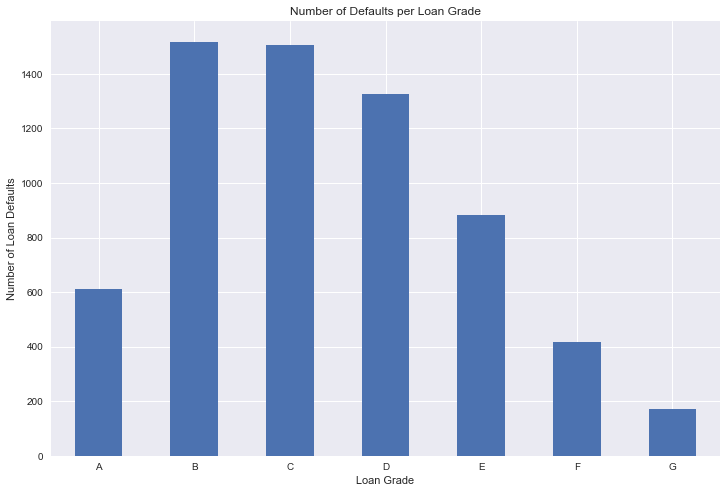

,loan_status
grade,
A,0.059904
B,0.122528
C,0.172082
D,0.220578
E,0.260165
F,0.319754
G,0.337891


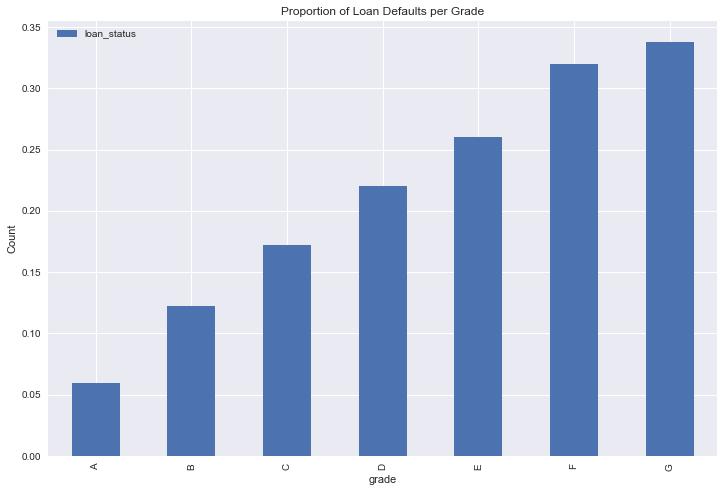

In [97]:
# Create a bar graph that counts the number of loans issued in each grade
df.grade.value_counts().sort_index().plot(kind = 'bar')
plt.title('Number of Loans Issued for Each Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Count')
plt.xticks(rotation='horizontal')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

# Create a bar plot that shows how many loans defaulted in each grade
ab = df
ab = df[df.loan_status == 1]
ab.grade.value_counts().sort_index().plot(kind = 'bar')
plt.title('Number of Defaults per Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Number of Loan Defaults')
plt.xticks(rotation='horizontal')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

# Create a proportion chart to show the proportion of loans that default in each grade
df.groupby(['grade'])[['loan_status']].mean().plot(kind='bar').set_ylabel('Count')
plt.title('Proportion of Loan Defaults per Grade')
df.groupby(['grade' ])[['loan_status']].mean()

47% of the loans that defaulted were given an B or C grade. However, an individual who receives a G grade loan is 5.6x more likely to default on their loan than an individual who receives an A grade loan and 2.8x more likely to default on their laon than a B grade. 

### Statistical Analysis

To better understand whether or not there is a significant relationship between a feature and whether or not a borrower's loan will be charged off, I performed t-tests and logistic regressions on each feature of interest. 

Before I began with the statistical analysis, I realized I needed to further narrow down which features to examine. When Lending Club receives a loan application, it gives that loan a grade (A-G). This grade is based on the applicant's loan information and credit score and is used to determine the interest rate on the loan. Since information like grade, interest rate, and installment are assigned to a borrower based on their potential risk as a borrower, I decided to only focus on the information provided by the borrower and use that to see if I can predict whether or not their loan will be charged off. This left the following features: 

* Funded Amount
* Employment Length
* Home Ownership
* Annual Income 
* Date Loan was Issued
* Purpose of Loan
* State of Residence
* Debt to Income Ratio 

#### Funded Amount

First I looked at the distribution of the funded loan amounts:

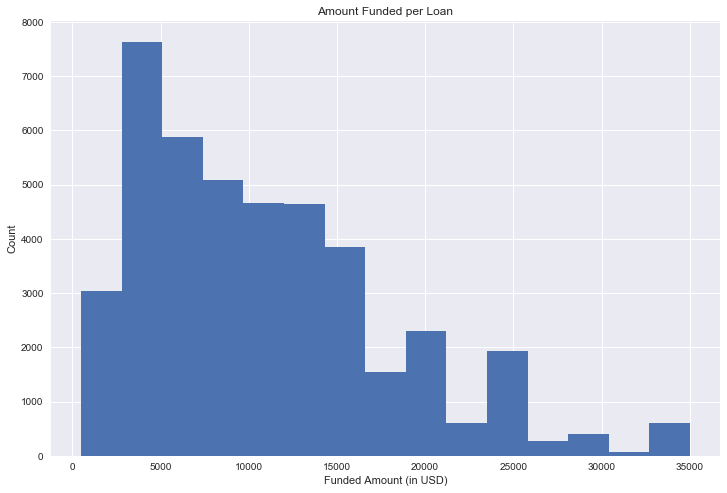

In [98]:
# Create a histogram of funded_amnt
plt.hist(df.funded_amnt, 15)
plt.title('Amount Funded per Loan')
plt.xlabel('Funded Amount (in USD)')
plt.ylabel('Count')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

Then I created a box plot to visualize whether there might be a noticeable difference between funded amounts for loans paid in full and loans charged off:

,funded_amnt
loan_status,
0,10702.134805
1,11492.190173


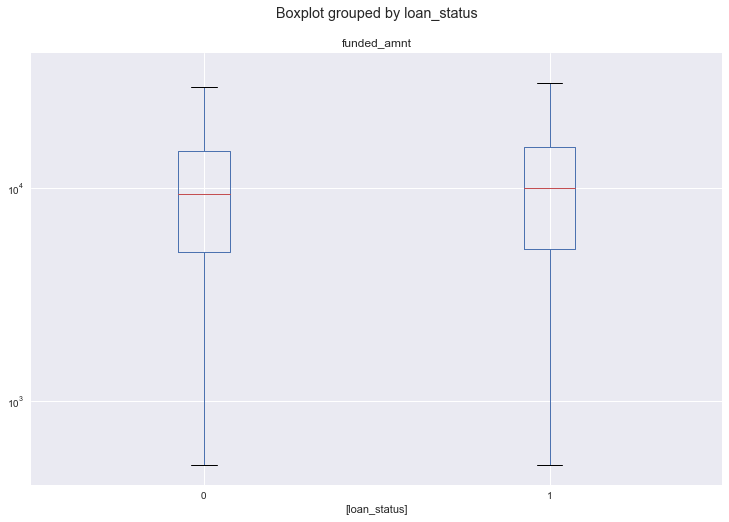

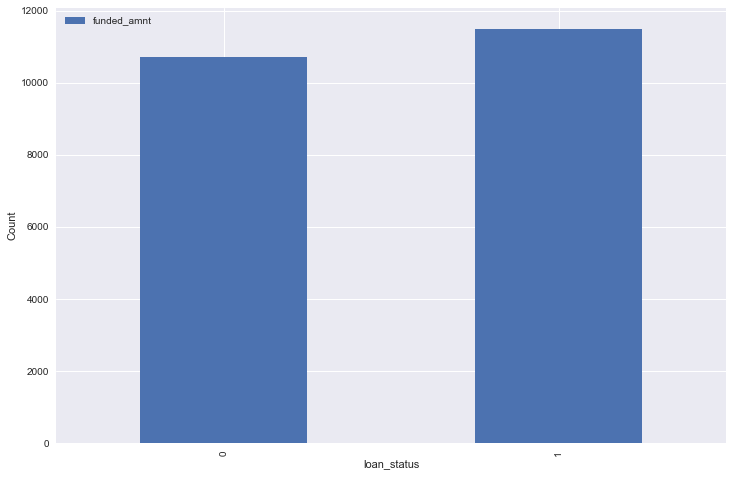

In [99]:
# Create box plot of funded_amnt and loan_status
df.boxplot(column=['funded_amnt'],by = ['loan_status']).set_yscale('log')
pd.DataFrame(df.groupby( ['loan_status'])['funded_amnt'].describe().loc[:,['mean','std']])

# Compare the ratio for funded_amnt and loan_status
df.groupby(['loan_status'])[['funded_amnt']].mean().plot(kind='bar').set_ylabel('Count')
df.groupby(['loan_status' ])[['funded_amnt']].mean()

Finally, I performed a t-test to test for correlation:

In [100]:
# Perform a t-test on funded_amnt
val1 = df.funded_amnt[df.loan_status == 0]
val2 = df.funded_amnt[df.loan_status == 1]
stats.ttest_ind(val1, val2)

Ttest_indResult(statistic=-8.1736933651248265, pvalue=3.0727095710409249e-16)

The p-value is below 0.05 which indicates there is a significant relationship between funded amount and loan status.

#### Employment Length

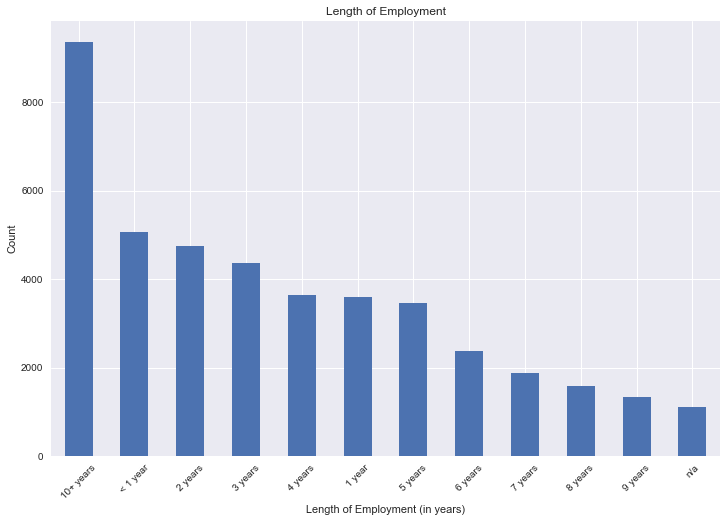

In [101]:
# Graph distribution of employment length
df.emp_length.value_counts().plot(kind = 'bar')
plt.title('Length of Employment')
plt.xlabel('Length of Employment (in years)')
plt.ylabel('Count')
plt.xticks(rotation='45')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

In [102]:
# Perform logistic regression
df_ind = pd.get_dummies(df['emp_length'])
df_ind['intercept'] = 1
df_ind['loan_status'] = df.loan_status

logit = sm.Logit(df_ind['loan_status'], df_ind [['1 year','10+ years','2 years','3 years','4 years','5 years',
                                                 '6 years','7 years','8 years','9 years','< 1 year', 'intercept']] )

result = logit.fit() 

result.summary()

Optimization terminated successfully.
         Current function value: 0.424087
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                42535
Model:                          Logit   Df Residuals:                    42523
Method:                           MLE   Df Model:                           11
Date:                Wed, 18 Jul 2018   Pseudo R-squ.:                0.001616
Time:                        22:18:35   Log-Likelihood:                -18039.
converged:                       True   LL-Null:                       -18068.
                                        LLR p-value:                 1.830e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
1 year        -0.4454      0.086     -5.185      0.000      -0.614      -0.277
10+ years     -0.3905      0.078     -5.030      0.000      -0.543      -0.238
2 years       -0.5692      0.084     -6.799      0.000      -0.733      -0.405
3 years       -0.5157      0.084     -6.125      0.000      -0.681      -0.351
4 years       -0.5264      0.086     -6.090      0.000      -0.696      -0.357
5 years       -0.4930      0.087     -5.678      0.000      -0.663      -0.323
6 years       -0.4849      0.093     -5.238      0.000      -0.666      -0.303
7 years       -0.4144      0.096     -4.307      0.000      -0.603      -0.226
8 years       -0.4748      0.101     -4.707      0.000      -0.672      -0.277
9 years       -0.6003      0.108     -5.561      0.000      -0.812      -0.389
< 1 year      -0.4837      0.082     -5.867      0.000      -0.645      -0.322
intercept     -1.2638      0.072    -17.467      0.000      -1.406      -1.122
==============================================================================
"""

P-value is well below 0.05 which indicates correlation between length of employment and loan status

#### Home Ownership

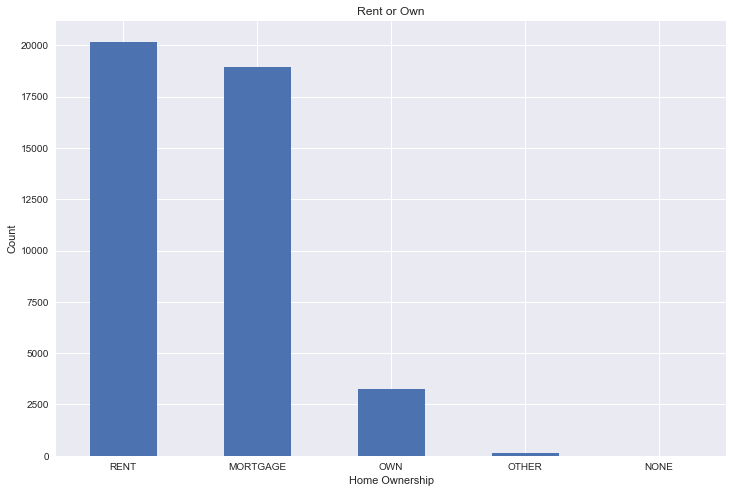

In [103]:
# Graph distribution of home ownership
df.home_ownership.value_counts().plot(kind = 'bar')
plt.title('Rent or Own')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.xticks(rotation='horizontal')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

In [105]:
# Perform logistic regression
df_ind = pd.get_dummies(df['home_ownership'])
df_ind['intercept'] = 1
df_ind['loan_status'] = df.loan_status

logit = sm.Logit(df_ind['loan_status'], df_ind [['MORTGAGE', 'OTHER', 'OWN', 'RENT', 'intercept']] )

result = logit.fit() 

result.summary()

Optimization terminated successfully.
         Current function value: 0.424482
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                42535
Model:                          Logit   Df Residuals:                    42530
Method:                           MLE   Df Model:                            4
Date:                Wed, 18 Jul 2018   Pseudo R-squ.:               0.0006844
Time:                        22:20:19   Log-Likelihood:                -18055.
converged:                       True   LL-Null:                       -18068.
                                        LLR p-value:                 5.695e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
MORTGAGE       0.1501      1.069      0.140      0.888      -1.946       2.246
OTHER          0.6404      1.089      0.588      0.557      -1.495       2.775
OWN            0.2289      1.070      0.214      0.831      -1.869       2.326
RENT           0.2796      1.069      0.261      0.794      -1.816       2.375
intercept     -1.9459      1.069     -1.820      0.069      -4.041       0.149
==============================================================================
"""

P-value is well below 0.05 which indicates a significant correlation between loan status and home ownership

#### Annual Income

,mean,std
loan_status,,
0,70164.277724,66280.247602
1,63366.870530,49684.103432


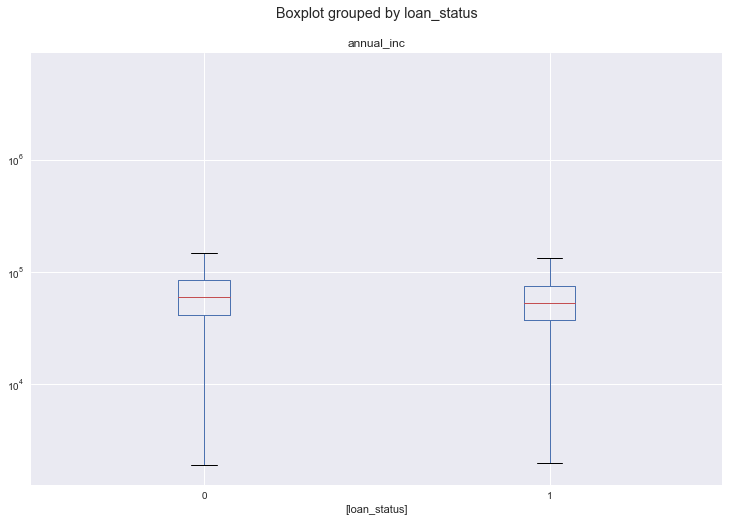

In [106]:
# Create boxplot to visualize relationship
df.boxplot(column=['annual_inc'],by = ['loan_status']).set_yscale('log')
pd.DataFrame(df.groupby( ['loan_status'])['annual_inc'].describe().loc[:,['mean','std']])

In [107]:
# Perform t-test
val1 = df.annual_inc[df.loan_status == 0]
val2 = df.annual_inc[df.loan_status == 1]
stats.ttest_ind(val1, val2)

Ttest_indResult(statistic=7.841202646289811, pvalue=4.5659583514162483e-15)

P-value is well below 0.05 which indicates a correlation between annual income and loan status

#### Month Loan was Issued

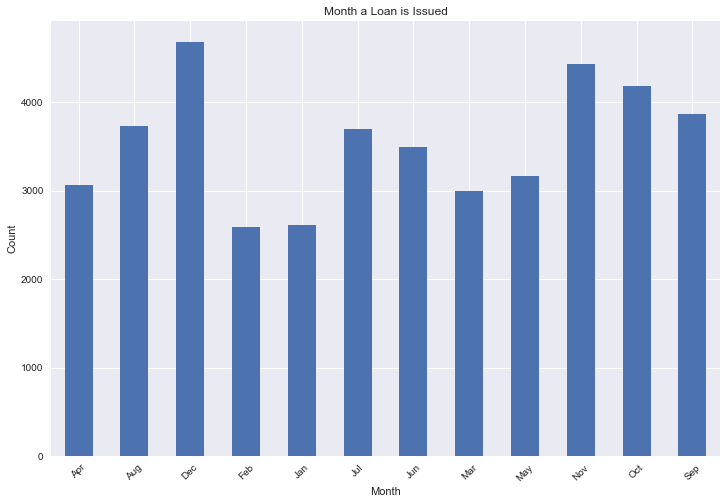

In [108]:
# Count number of loans given in each month
df.issue_month.value_counts().sort_index().plot(kind = 'bar')
plt.title('Month a Loan is Issued')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation='45')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

In [109]:
# Perform logistic regression
df_ind = pd.get_dummies(df['issue_month'])
df_ind['intercept'] = 1
df_ind['loan_status'] = df.loan_status

logit = sm.Logit(df_ind['loan_status'], df_ind [['Aug', 'Dec',  'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 
                                                 'Nov', 'Oct', 'Sep','intercept']] )

result = logit.fit() 

result.summary()

Optimization terminated successfully.
         Current function value: 0.424498
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                42535
Model:                          Logit   Df Residuals:                    42523
Method:                           MLE   Df Model:                           11
Date:                Wed, 18 Jul 2018   Pseudo R-squ.:               0.0006478
Time:                        22:23:21   Log-Likelihood:                -18056.
converged:                       True   LL-Null:                       -18068.
                                        LLR p-value:                   0.01547
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Aug           -0.0086      0.070     -0.123      0.902      -0.146       0.129
Dec            0.1426      0.065      2.183      0.029       0.015       0.271
Feb           -0.0685      0.078     -0.884      0.377      -0.221       0.083
Jan            0.0970      0.075      1.295      0.195      -0.050       0.244
Jul            0.0266      0.070      0.381      0.703      -0.110       0.163
Jun            0.1225      0.070      1.762      0.078      -0.014       0.259
Mar            0.0033      0.074      0.045      0.964      -0.141       0.147
May            0.1496      0.071      2.112      0.035       0.011       0.288
Nov            0.1059      0.066      1.597      0.110      -0.024       0.236
Oct            0.1205      0.067      1.799      0.072      -0.011       0.252
Sep            0.1095      0.068      1.607      0.108      -0.024       0.243
intercept     -1.8002      0.052    -34.781      0.000      -1.902      -1.699
==============================================================================
"""

P-value is below 0.05 which indicates correlation between the month a loan is issued and the loan status

#### Purpose of Loan

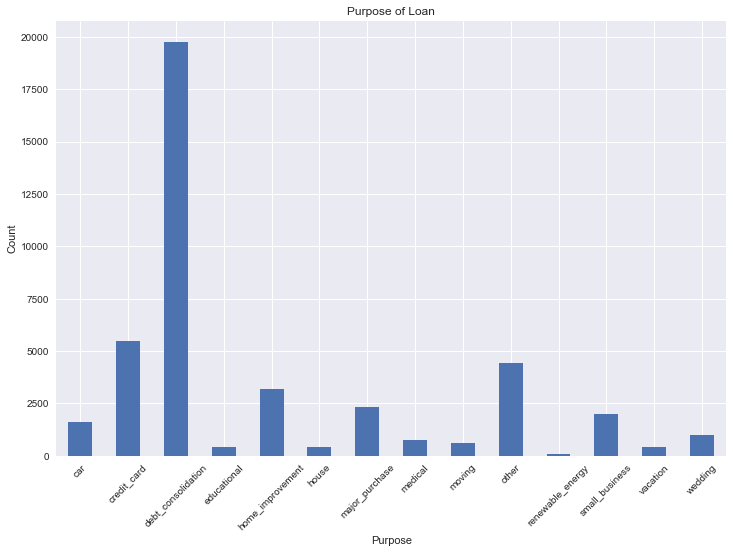

In [110]:
# Create a graph to count the number of each loan purpose
df.purpose.value_counts().sort_index().plot(kind = 'bar')
plt.title('Purpose of Loan')
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.xticks(rotation='45')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

In [112]:
# Perform logistic regression
df_ind = pd.get_dummies(df['purpose'])
df_ind['intercept'] = 1
df_ind['loan_status'] = df['loan_status'] 

df_ind= df_ind.fillna(0) 

logit = sm.Logit(df_ind['loan_status'], df_ind [['credit_card', 'debt_consolidation',  'educational', 
                                                  'home_improvement',  'house',  'major_purchase',  'medical', 
                                                  'moving',  'other',  'renewable_energy', 'small_business', 'vacation',
                                                 'wedding', 'intercept']] )

result = logit.fit() 

result.summary()

Optimization terminated successfully.
         Current function value: 0.420097
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                42535
Model:                          Logit   Df Residuals:                    42521
Method:                           MLE   Df Model:                           13
Date:                Wed, 18 Jul 2018   Pseudo R-squ.:                 0.01101
Time:                        22:25:12   Log-Likelihood:                -17869.
converged:                       True   LL-Null:                       -18068.
                                        LLR p-value:                 6.579e-77
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
credit_card            0.0566      0.091      0.621      0.535      -0.122       0.235
debt_consolidation     0.4318      0.083      5.214      0.000       0.269       0.594
educational            0.7867      0.144      5.451      0.000       0.504       1.070
home_improvement       0.2364      0.096      2.464      0.014       0.048       0.424
house                  0.4941      0.154      3.218      0.001       0.193       0.795
major_purchase        -0.0116      0.105     -0.111      0.912      -0.218       0.194
medical                0.5348      0.126      4.243      0.000       0.288       0.782
moving                 0.5357      0.133      4.022      0.000       0.275       0.797
other                  0.5440      0.090      6.058      0.000       0.368       0.720
renewable_energy       0.6619      0.261      2.536      0.011       0.150       1.173
small_business         1.1591      0.095     12.230      0.000       0.973       1.345
vacation               0.3661      0.162      2.255      0.024       0.048       0.684
wedding                0.0150      0.129      0.116      0.908      -0.239       0.269
intercept             -2.1205      0.080    -26.355      0.000      -2.278      -1.963
======================================================================================
"""

P-value is nearly 0 which indicates a strong correlation between a loan's purpose and the loan status.

#### State of Residence

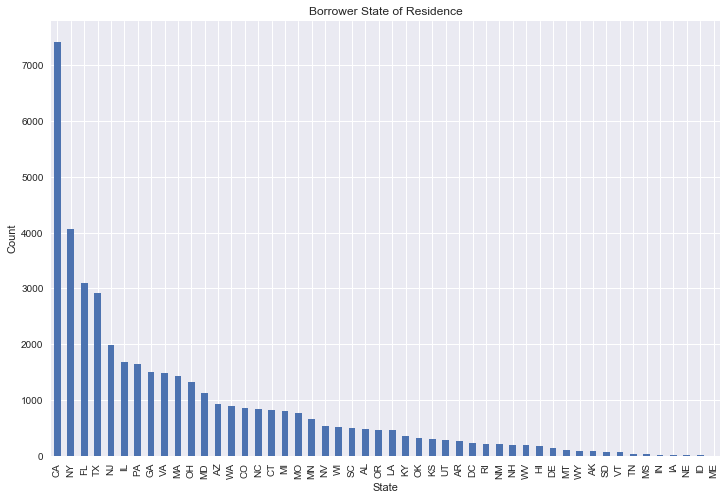

In [114]:
# Create a graph to visualize the distribution of loans per state
df.addr_state.value_counts().plot(kind = 'bar')
plt.title('Borrower State of Residence')
plt.xlabel('State')
plt.ylabel('Count')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.show()

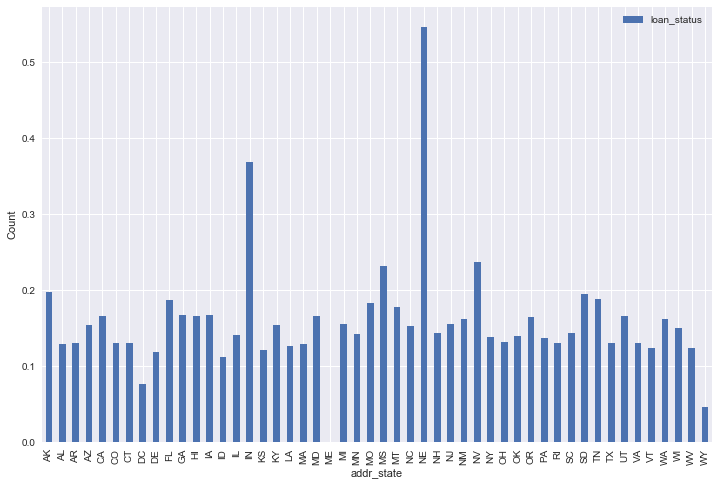

In [117]:
# Create a graph for the proportion of loans that default in each state
df.groupby(['addr_state'])[['loan_status']].mean().plot(kind='bar').set_ylabel('Count')

In [118]:
# Perform logistic Regression
df_ind = pd.get_dummies(df['addr_state'])
df_ind['intercept'] = 1
df_ind['loan_status'] = df['loan_status'] 

df_ind= df_ind.fillna(0) 

logit = sm.Logit(df_ind['loan_status'], df_ind [['AL','AR','AZ','CA','CO','CT','DC','DE','FL','GA','HI','IA','ID',
                                                 'IL','IN','KS','KY','LA','MA','MD','ME','MI','MN','MO','MS','MT','NC','NE',
                                                 'NH','NJ','NM','NV','NY','OH','OK','OR','PA','RI','SC','SD','TN','TX',
                                                 'UT','VA','VT','WA','WI','WV','WY','intercept']] )

result = logit.fit() 

result.summary()

Optimization terminated successfully.
         Current function value: 0.422669
         Iterations 17


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                42535
Model:                          Logit   Df Residuals:                    42485
Method:                           MLE   Df Model:                           49
Date:                Wed, 18 Jul 2018   Pseudo R-squ.:                0.004953
Time:                        22:28:41   Log-Likelihood:                -17978.
converged:                       True   LL-Null:                       -18068.
                                        LLR p-value:                 1.070e-16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AL            -0.5170      0.303     -1.706      0.088      -1.111       0.077
AR            -0.4977      0.327     -1.521      0.128      -1.139       0.144
AZ            -0.3083      0.286     -1.079      0.280      -0.868       0.251
CA            -0.2145      0.273     -0.787      0.431      -0.749       0.320
CO            -0.5043      0.289     -1.743      0.081      -1.071       0.063
CT            -0.5009      0.290     -1.727      0.084      -1.070       0.068
DC            -1.0986      0.370     -2.968      0.003      -1.824      -0.373
DE            -0.6140      0.380     -1.617      0.106      -1.358       0.130
FL            -0.0676      0.275     -0.246      0.806      -0.606       0.471
GA            -0.2109      0.279     -0.755      0.450      -0.759       0.337
HI            -0.2152      0.337     -0.639      0.523      -0.875       0.444
IA            -0.2085      0.821     -0.254      0.799      -1.817       1.400
ID            -0.6785      1.095     -0.620      0.535      -2.824       1.467
IL            -0.4148      0.280     -1.482      0.138      -0.963       0.134
IN             0.8619      0.547      1.575      0.115      -0.211       1.935
KS            -0.5839      0.324     -1.803      0.071      -1.219       0.051
KY            -0.3088      0.308     -1.003      0.316      -0.912       0.295
LA            -0.5376      0.305     -1.762      0.078      -1.135       0.060
MA            -0.5120      0.282     -1.816      0.069      -1.065       0.041
MD            -0.2182      0.282     -0.773      0.440      -0.772       0.335
ME          -126.0556   2.74e+27   -4.6e-26      1.000   -5.38e+27    5.38e+27
MI            -0.2987      0.288     -1.037      0.300      -0.863       0.266
MN            -0.4053      0.293     -1.382      0.167      -0.980       0.169
MO            -0.0952      0.286     -0.332      0.740      -0.657       0.466
MS             0.1969      0.539      0.366      0.715      -0.859       1.252
MT            -0.1353      0.381     -0.356      0.722      -0.881       0.610
NC            -0.3196      0.288     -1.112      0.266      -0.883       0.244
NE             1.5832      0.663      2.387      0.017       0.283       2.883
NH            -0.3847      0.341     -1.127      0.260      -1.054       0.284
NJ            -0.2956      0.278     -1.064      0.287      -0.840       0.249
NM            -0.2501      0.331     -0.756      0.450      -0.898       0.398
NV             0.2328      0.289      0.804      0.421      -0.335       0.800
NY            -0.4373      0.275     -1.592      0.111      -0.975       0.101
OH            -0.4919      0.283     -1.740      0.082      -1.046       0.062
OK            -0.4244      0.316     -1.344      0.179      -1.043       0.194
OR            -0.2240      0.298     -0.751      0.452      -0.808       0.360
PA            -0.4456      0.280     -1.591      0.112      -0.995       0.103
RI            -0.5018      0.340     -1.474      0.140      -1.169       0.165
SC

P-value is below 0.05 which indicates a correlation between borrower's state of residence and loan status

#### Debt to Income Ratio

,mean,std
loan_status,,
0,13.253252,6.731947
1,14.045559,6.655208


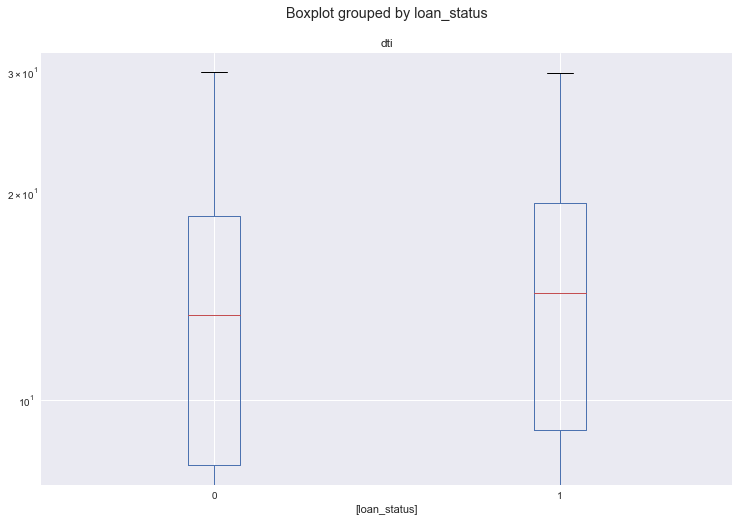

In [119]:
# Create a box plot to visualize the difference between loan status
df.boxplot(column=['dti'],by = ['loan_status']).set_yscale('log')
pd.DataFrame(df.groupby( ['loan_status'])['dti'].describe().loc[:,['mean','std']])

In [120]:
# Perform t-test
val1 = df.dti[df.loan_status == 0]
val2 = df.dti[df.loan_status == 1]
stats.ttest_ind(val1, val2)

Ttest_indResult(statistic=-8.7104794877852409, pvalue=3.1327064696533274e-18)

P-value is below 0.05 which indicates correlation between loan status and debt to income ratio.

## Conclusions

My statistical analysis revealed that all 8 features are significantly correlated to the status of a loan and whether or not it is charged off. I will be further examining them as I move into the machine learning portion of my project.